## Import Libraries

In [25]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import ViTForImageClassification, ViTFeatureExtractor, ViTImageProcessor, AutoModelForImageClassification

### Create a dataFrame with image_path and label column

In [4]:
root_path = '/kaggle/input/brisc2025/brisc2025/classification_task/train'

image_paths = []
labels = []

for label in os.listdir(root_path):
    label_path = os.path.join(root_path, label)
    if os.path.isdir(label_path):
        for img_file in os.listdir(label_path):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(label_path, img_file))
                labels.append(label)

df = pd.DataFrame({'image_path': image_paths, 'label': labels})

In [5]:
df

,image_path,label
0,/kaggle/input/brisc2025/brisc2025/classificati...,pituitary
1,/kaggle/input/brisc2025/brisc2025/classificati...,pituitary
2,/kaggle/input/brisc2025/brisc2025/classificati...,pituitary
3,/kaggle/input/brisc2025/brisc2025/classificati...,pituitary
4,/kaggle/input/brisc2025/brisc2025/classificati...,pituitary
...,...,...
4995,/kaggle/input/brisc2025/brisc2025/classificati...,glioma
4996,/kaggle/input/brisc2025/brisc2025/classificati...,glioma
4997,/kaggle/input/brisc2025/brisc2025/classificati...,glioma
4998,/kaggle/input/brisc2025/brisc2025/classificati...,glioma


In [6]:
df.shape

(5000, 2)

In [7]:
df.columns

Index(['image_path', 'label'], dtype='object')

In [8]:
df.duplicated().sum()

0

In [9]:
df.isnull().sum()

image_path    0
label         0
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  5000 non-null   object
 1   label       5000 non-null   object
dtypes: object(2)
memory usage: 78.3+ KB


In [11]:
df['label'].unique()

array(['pituitary', 'no_tumor', 'meningioma', 'glioma'], dtype=object)

In [12]:
df['label'].value_counts()

label
pituitary     1457
meningioma    1329
glioma        1147
no_tumor      1067
Name: count, dtype: int64

### Visualize how many samples each type of class contain

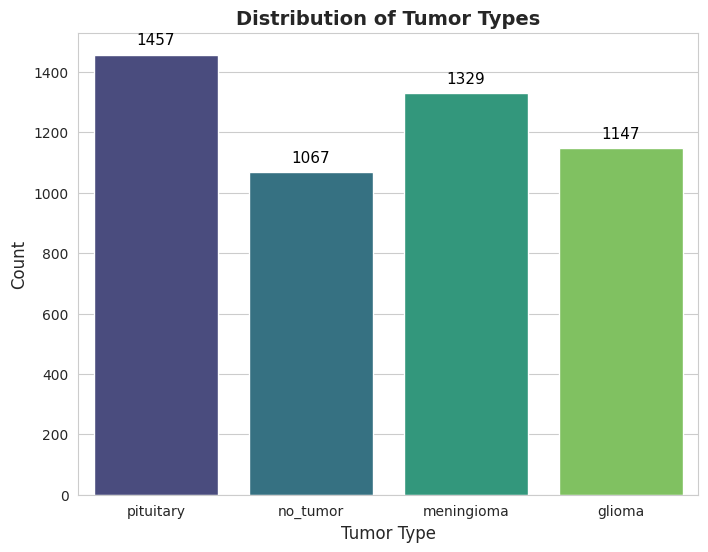

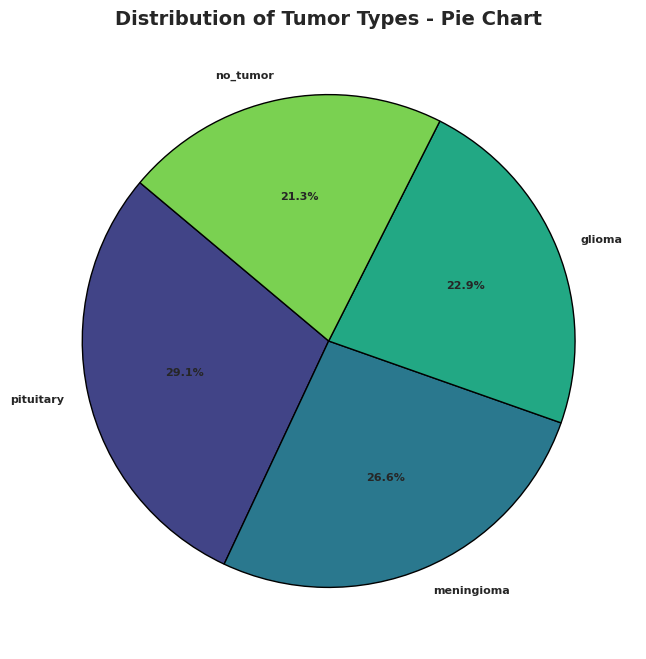

In [13]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=df, x="label", palette="viridis", ax=ax)

ax.set_title("Distribution of Tumor Types", fontsize=14, fontweight='bold')
ax.set_xlabel("Tumor Type", fontsize=12)
ax.set_ylabel("Count", fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=11, color='black', 
                xytext=(0, 5), textcoords='offset points')

plt.show()

label_counts = df["label"].value_counts()

fig, ax = plt.subplots(figsize=(10, 8))
colors = sns.color_palette("viridis", len(label_counts))

ax.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', 
       startangle=140, colors=colors, textprops={'fontsize': 8, 'weight': 'bold'},
       wedgeprops={'edgecolor': 'black', 'linewidth': 1})

ax.set_title("Distribution of Tumor Types - Pie Chart", fontsize=14, fontweight='bold')

plt.show()

### Plot some samples of each type of class

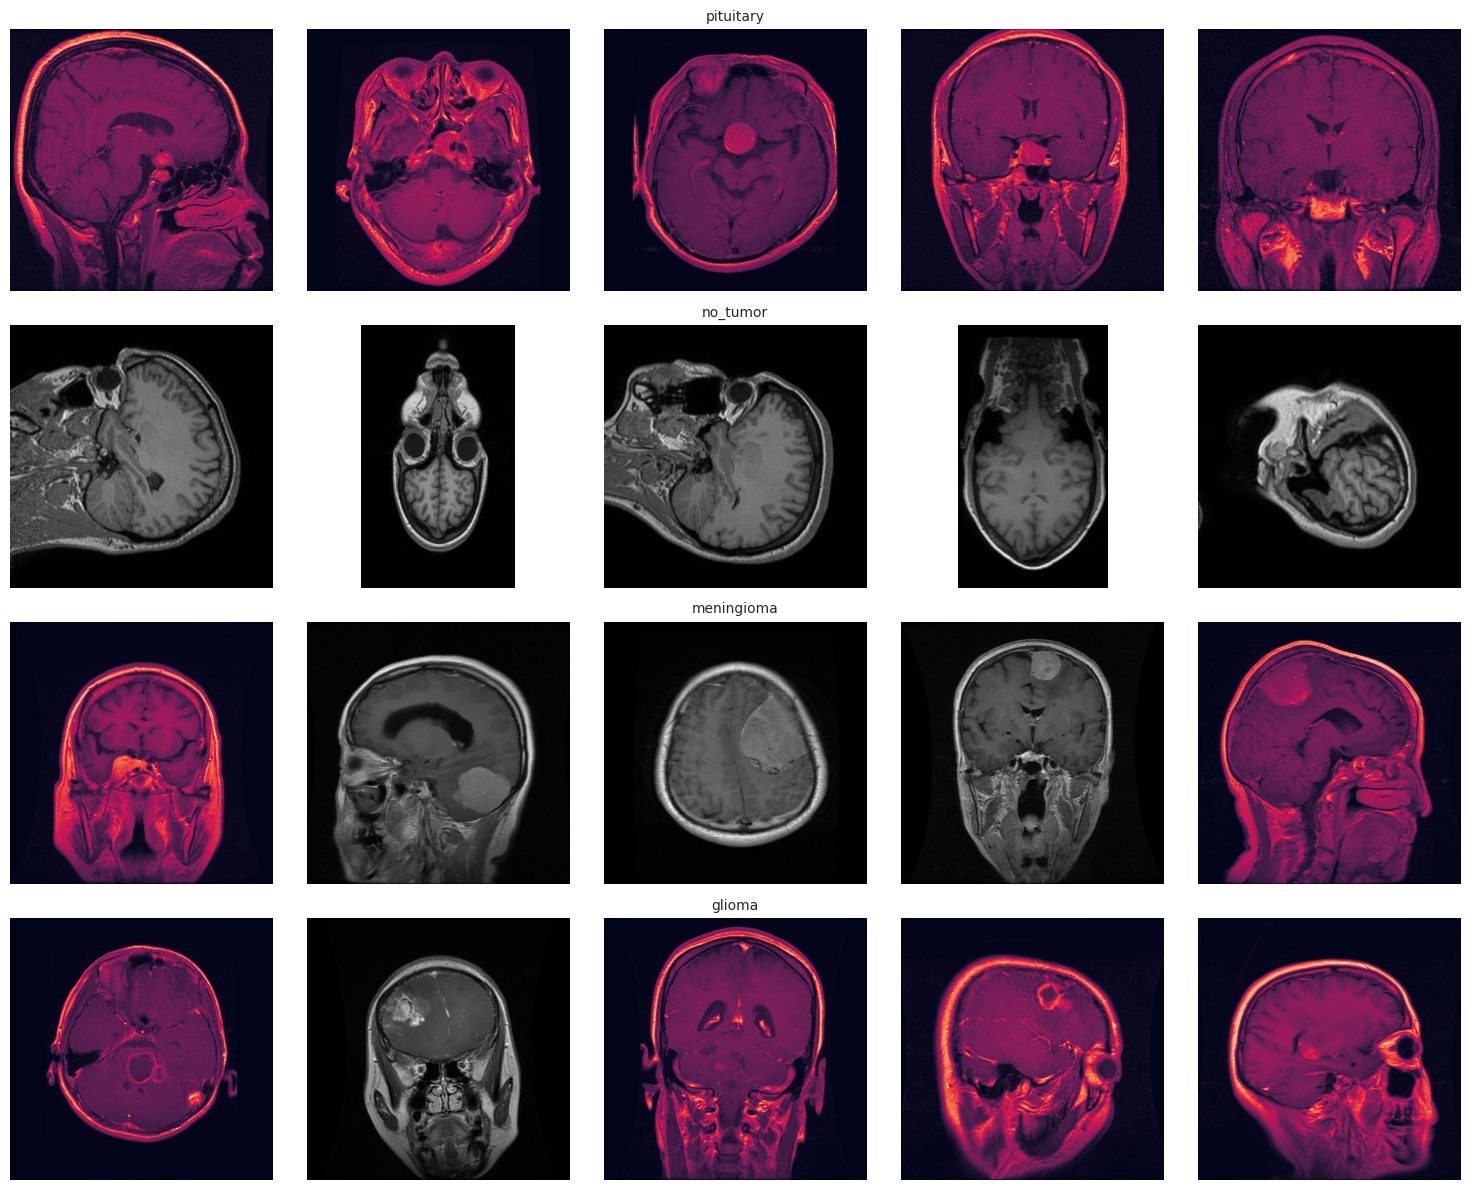

In [14]:
num_images = 5

unique_labels = df['label'].unique()

plt.figure(figsize=(15, len(unique_labels) * 3))

for row_idx, label in enumerate(unique_labels):
  
    label_images = df[df['label'] == label].head(num_images)['image_path'].tolist()
    
    for col_idx, img_path in enumerate(label_images):
        plt_idx = row_idx * num_images + col_idx + 1
        plt.subplot(len(unique_labels), num_images, plt_idx)
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis('off')
        if col_idx == 2:  
            plt.title(label, fontsize=10)

plt.tight_layout()
plt.show()

In [15]:
import warnings
warnings.filterwarnings('ignore')

### Balance each type of class sample numbers

In [17]:
max_samples = df['label'].value_counts().max()

balanced_df = df.groupby('label', group_keys=False).apply(
    lambda x: x.sample(n=max_samples, replace=True, random_state=42)
).reset_index(drop=True)

balanced_df = balanced_df[['image_path', 'label']]

In [18]:
df = balanced_df

In [20]:
df

,image_path,label
0,/kaggle/input/brisc2025/brisc2025/classificati...,glioma
1,/kaggle/input/brisc2025/brisc2025/classificati...,glioma
2,/kaggle/input/brisc2025/brisc2025/classificati...,glioma
3,/kaggle/input/brisc2025/brisc2025/classificati...,glioma
4,/kaggle/input/brisc2025/brisc2025/classificati...,glioma
...,...,...
5823,/kaggle/input/brisc2025/brisc2025/classificati...,pituitary
5824,/kaggle/input/brisc2025/brisc2025/classificati...,pituitary
5825,/kaggle/input/brisc2025/brisc2025/classificati...,pituitary
5826,/kaggle/input/brisc2025/brisc2025/classificati...,pituitary


In [26]:
class BrainTumorDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform
        self.label_map = {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 0]
        label = self.label_map[self.data.iloc[idx, 1]]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

feature_extractor = ViTImageProcessor.from_pretrained('Falconsai/nsfw_image_detection')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

dataset = BrainTumorDataset(dataframe=df, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model = AutoModelForImageClassification.from_pretrained(
    "Falconsai/nsfw_image_detection",
    num_labels=4,
    ignore_mismatched_sizes=True  # important because classification head is different
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 3
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.savefig('loss_plot.png')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.savefig('accuracy_plot.png')
plt.close()

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.label_map.keys(), yticklabels=dataset.label_map.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.close()

print(classification_report(all_labels, all_preds, target_names=dataset.label_map.keys()))

config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at Falconsai/nsfw_image_detection and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Train Loss: 0.2943, Train Acc: 92.17%, Val Loss: 0.1044, Val Acc: 97.26%
Epoch 2, Train Loss: 0.0607, Train Acc: 98.69%, Val Loss: 0.1048, Val Acc: 97.43%
Epoch 3, Train Loss: 0.0304, Train Acc: 99.46%, Val Loss: 0.0434, Val Acc: 98.80%
              precision    recall  f1-score   support

      glioma       0.99      0.99      0.99       279
  meningioma       0.98      0.98      0.98       310
    no_tumor       1.00      0.99      0.99       257
   pituitary       0.98      0.99      0.99       320

    accuracy                           0.99      1166
   macro avg       0.99      0.99      0.99      1166
weighted avg       0.99      0.99      0.99      1166



In [27]:
model.save_pretrained("/kaggle/working/brain_tumor_vit_model")
feature_extractor.save_pretrained("/kaggle/working/brain_tumor_vit_model")

!zip -r brain_tumor_vit_model.zip /kaggle/working/brain_tumor_vit_model


  adding: kaggle/working/brain_tumor_vit_model/ (stored 0%)
  adding: kaggle/working/brain_tumor_vit_model/config.json (deflated 52%)
  adding: kaggle/working/brain_tumor_vit_model/model.safetensors (deflated 7%)
  adding: kaggle/working/brain_tumor_vit_model/preprocessor_config.json (deflated 47%)


In [28]:
import os
print(os.listdir("brain_tumor_vit_model"))


['config.json', 'model.safetensors', 'preprocessor_config.json']


In [21]:
import os
print(os.getcwd())  # current directory
print(os.listdir("brain_tumor_vit_model"))


/kaggle/working
['config.json', 'model.safetensors', 'preprocessor_config.json']


In [21]:
from transformers import ViTForImageClassification, ViTFeatureExtractor

model = ViTForImageClassification.from_pretrained("brain_tumor_vit_model")
feature_extractor = ViTFeatureExtractor.from_pretrained("brain_tumor_vit_model")


In [19]:
path = '/kaggle/working/'
files = os.listdir(path)
image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')
image_files = [f for f in files if f.lower().endswith(image_extensions)]

print("Found these images:", image_files)

Found these images: ['loss_plot.png', 'accuracy_plot.png', 'confusion_matrix.png']


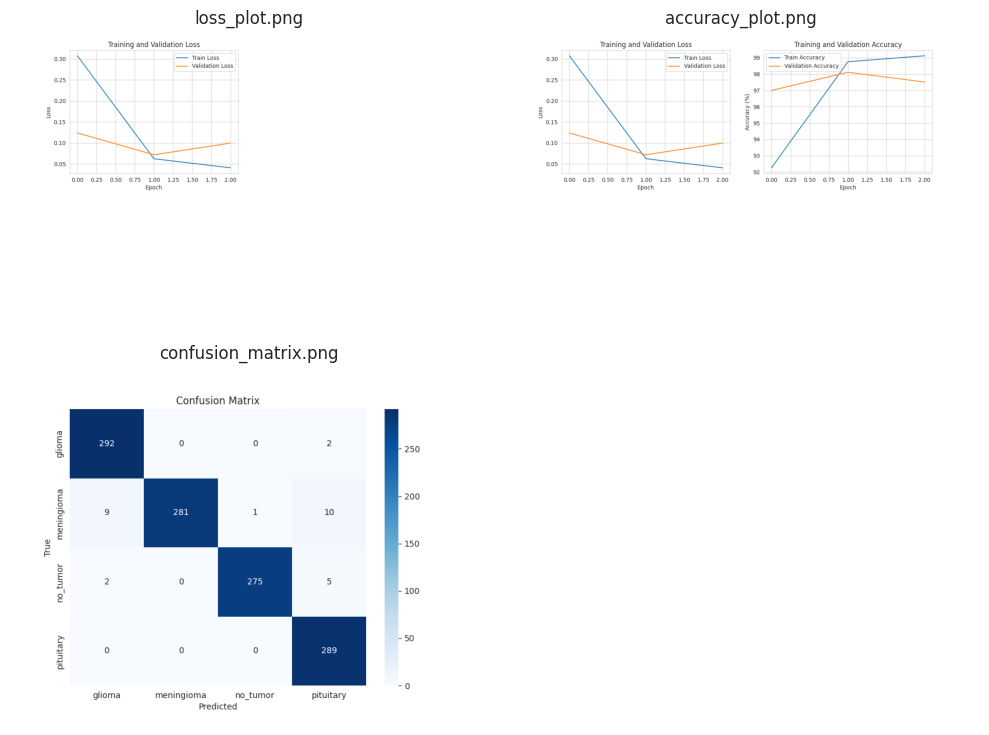

In [20]:
n_images = len(image_files)
if n_images == 0:
    print("No images found in /kaggle/working/.")
else:
    n_cols = 2
    n_rows = (n_images + n_cols - 1) // n_cols

    plt.figure(figsize=(n_cols * 5, n_rows * 5))

    for idx, filename in enumerate(image_files):
        img_path = os.path.join(path, filename)
        img = Image.open(img_path)

        ax = plt.subplot(n_rows, n_cols, idx + 1)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(filename)

    plt.tight_layout()
    plt.show()

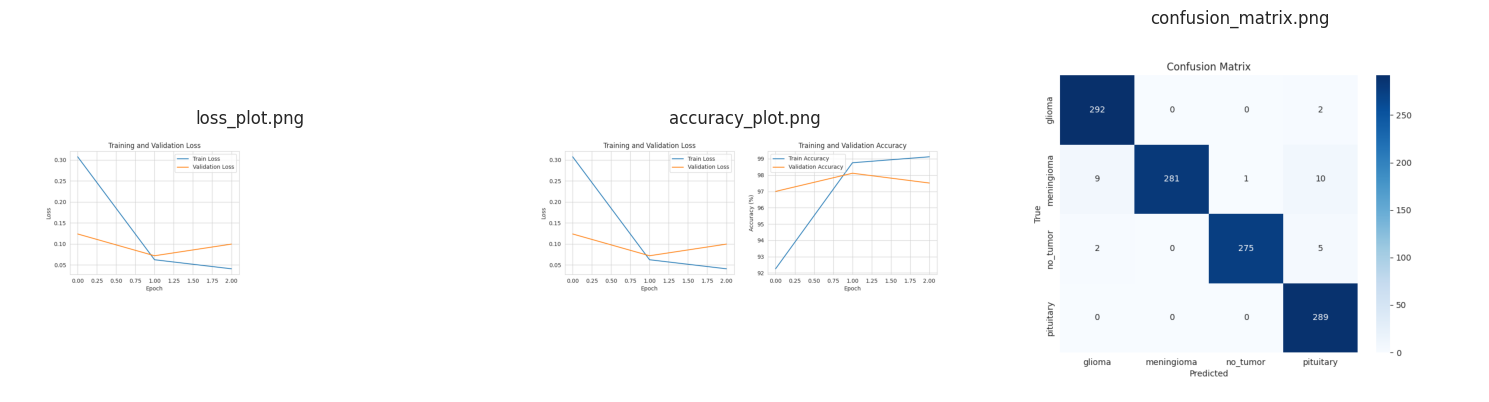

In [21]:
def display_images_from_dir(directory, max_images=9, cols=3, figsize=(15, 15)):
    files = os.listdir(directory)
    image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
    image_files = image_files[:max_images]
    
    if not image_files:
        print("No images found in", directory)
        return

    rows = (len(image_files) + cols - 1) // cols
    plt.figure(figsize=figsize)

    for i, fname in enumerate(image_files):
        img = Image.open(os.path.join(directory, fname))
        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(fname)

    plt.tight_layout()
    plt.show()

display_images_from_dir('/kaggle/working/', max_images=6, cols=3)